
<h1 style="text-align:center; font-size: 40px;">Title</h1>



# Import libraries 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.spatial.distance import directed_hausdorff
from skimage.exposure import histogram
from skimage._shared.utils import warn
from skimage.filters._multiotsu import (
    _get_multiotsu_thresh_indices
)
import time

# Load the image

In [2]:
image_path = "12_jpg.rf.21eba5a77b6113c9d7f9b182092a02d3.jpg"
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# functions

In [3]:
def dice_coefficient(seg_mask, gt_mask):
    intersection = np.logical_and(seg_mask, gt_mask)
    return 2.0 * intersection.sum() / (seg_mask.sum() + gt_mask.sum())

def jaccard_index(seg_mask, gt_mask):
    intersection = np.logical_and(seg_mask, gt_mask)
    union = np.logical_or(seg_mask, gt_mask)
    return intersection.sum() / union.sum()

def sorensen_dice_coefficient(seg_mask, gt_mask):
    intersection = np.logical_and(seg_mask, gt_mask)
    return 2.0 * intersection.sum() / (seg_mask.sum() + gt_mask.sum())
 
def _validate_image_histogram(image, hist, nbins=None, normalize=False):
  
    if image is None and hist is None:
        raise Exception("Either image or hist must be provided.")

    if hist is not None:
        if isinstance(hist, (tuple, list)):
            counts, bin_centers = hist
        else:
            counts = hist
            bin_centers = np.arange(counts.size)

        if counts[0] == 0 or counts[-1] == 0:
            cond = counts > 0
            start = np.argmax(cond)
            end = cond.size - np.argmax(cond[::-1])
            counts, bin_centers = counts[start:end], bin_centers[start:end]
    else:
        counts, bin_edges = histogram(
            image.reshape(-1), nbins, source_range='image', normalize=normalize
        )
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return counts.astype('float32', copy=False), bin_centers

import time

def threshold_multiotsu(image=None, classes=4, nbins=256, *, hist=None):
    start_time = time.time()  # Commencer le chronométrage
    
    if image is not None and image.ndim > 2 and image.shape[-1] in (3, 4):
        warn(f'threshold_multiotsu is expected to work correctly only for '
             f'grayscale images; image shape {image.shape} looks like '
             f'that of an RGB image.')

    # Calcul de l'histogramme et de la probabilité de chaque niveau de gris.
    prob, bin_centers = _validate_image_histogram(image, hist, nbins,
                                                  normalize=True)
    prob = prob.astype('float32', copy=False)

    nvalues = np.count_nonzero(prob)
    if nvalues < classes:
        msg = (f'After discretization into bins, the input image has '
               f'only {nvalues} different values. It cannot be thresholded '
               f'in {classes} classes. If there are more unique values '
               f'before discretization, try increasing the number of bins '
               f'(`nbins`).')
        raise ValueError(msg)
    elif nvalues == classes:
        thresh_idx = np.flatnonzero(prob)[:-1]
    else:
        # Obtenir les indices de seuil
        thresh_idx = _get_multiotsu_thresh_indices(prob, classes - 1)
    
    end_time = time.time()  # Arrêter le chronométrage
    print("Time taken for multi otsu function:", end_time - start_time, "seconds")

    thresh = bin_centers[thresh_idx]

    return thresh


def apply_multiotsu_thresholds(image, thresholds):
    result = np.zeros_like(image)
    for i in range(len(thresholds)):
        result[image > thresholds[i]] = 255 * (i + 1) / len(thresholds)
    return result

def fitness_function(thresholds, image):
    segmented_image = apply_multiotsu_thresholds(image, thresholds)
    return -psnr(image, segmented_image)

def selection(population, fitness_scores):
    sorted_indices = np.argsort(fitness_scores)
    return population[sorted_indices[-2:]], fitness_scores[sorted_indices[-2:]]

def crossover(parents):
    crossover_point = np.random.randint(1, len(parents[0]))
    child1 = np.concatenate((parents[0][:crossover_point], parents[1][crossover_point:]))
    child2 = np.concatenate((parents[1][:crossover_point], parents[0][crossover_point:]))
    return child1, child2

def mutation(child, mutation_rate):
    for i in range(len(child)):
        if np.random.rand() < mutation_rate:
            child[i] = np.random.randint(0, 255)
    return child
def genetic_algorithm(image, num_thresholds, population_size=4, num_generations=4, mutation_rate=0.25):
    start_time = time.time()
    population = np.random.randint(0, 255, size=(population_size, num_thresholds))
    for generation in range(num_generations):
        fitness_scores = np.array([fitness_function(thresholds, image) for thresholds in population])
        selected_population, selected_fitness = selection(population, fitness_scores)
        new_population = []
        for _ in range(population_size // 2):
            parents = selected_population[np.random.choice(range(len(selected_population)), size=2, replace=False)]
            child1, child2 = crossover(parents)
            child1 = mutation(child1, mutation_rate)
            child2 = mutation(child2, mutation_rate)
            new_population.extend([child1, child2])
        population = np.array(new_population)
    best_thresholds = population[np.argmax(fitness_scores)]
    end_time = time.time()
    print("Time taken for genetic algorithm optimization:", end_time - start_time, "seconds")
    return np.sort(best_thresholds)

# multi-otsu thresholding without filtering 

Time taken for multi otsu function: 0.6472923755645752 seconds


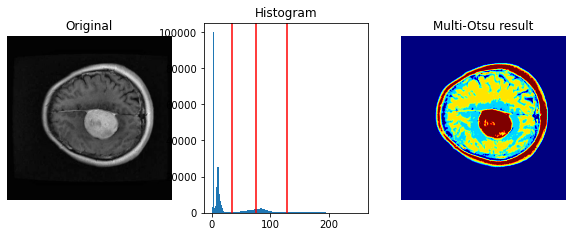

In [4]:
# Calculate multi-Otsu thresholds
thresholds = threshold_multiotsu(image)

# Segment the image into different regions
regions = np.digitize(image, bins=thresholds)

# Display the original image, histogram, and multi-Otsu result
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5))

# Original image
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original')
ax[0].axis('off')

# Histogram with threshold lines
ax[1].hist(image.ravel(), bins=255)
ax[1].set_title('Histogram')
for thresh in thresholds:
    ax[1].axvline(thresh, color='r')

# Multi-Otsu result
ax[2].imshow(regions, cmap='jet')  
ax[2].set_title('Multi-Otsu result')
ax[2].axis('off')

plt.subplots_adjust()
plt.show()



# Calculate the measures


In [5]:
# Calculate PSNR, SSIM, Dice Coefficient, Jaccard Index, and Sørensen-Dice Coefficient
psnr_value = psnr(image, regions)
ssim_value = ssim(image, regions)
dsc_value = dice_coefficient(image, regions)
ji_value = jaccard_index(image, regions)

#print the values
print("the psnr : ",psnr_value)
print()
print("the ssim : ",ssim_value)
print()
print("Dice Similarity Coefficient : ", dsc_value)
print()
print("Jaccard Index : ", ji_value)



the psnr :  12.769108736762584

the ssim :  0.14239835859783326

Dice Similarity Coefficient :  0.017300278528411615

Jaccard Index :  0.3186275946275946


C:\Users\Y\AppData\Local\Temp/ipykernel_8520/3544489487.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_value = psnr(image, regions)
C:\Users\Y\AppData\Local\Temp/ipykernel_8520/3544489487.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_value = ssim(image, regions)


# multi-otsu thresholding with median filter

Time taken for multi otsu function: 0.5838327407836914 seconds
Time taken for multi otsu function: 0.12954497337341309 seconds


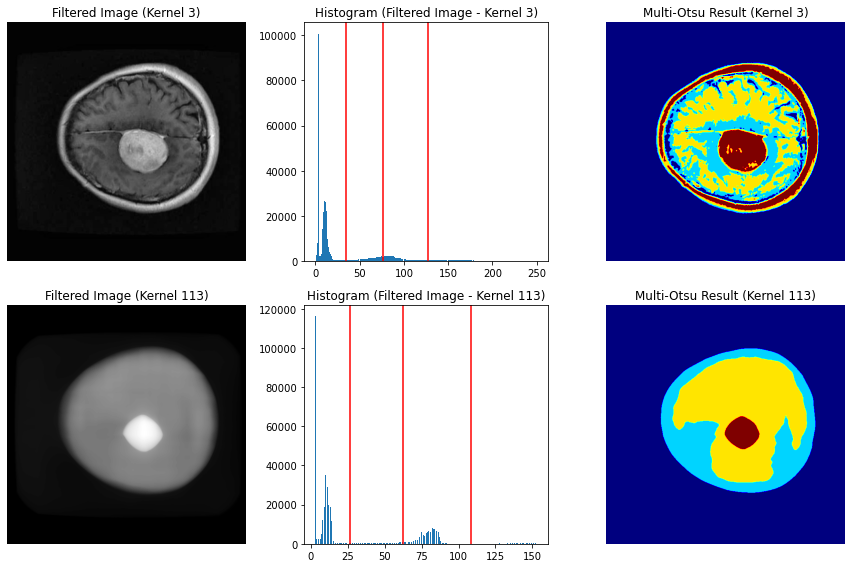

In [6]:
#apply the filters
image_filtre_3 = cv2.medianBlur(image, 3)
image_filtre_113 = cv2.medianBlur(image,113 )

# Calculate multi-Otsu thresholds
thresholds = threshold_multiotsu(image_filtre_3, classes=4)
thresholdss = threshold_multiotsu(image_filtre_113, classes=4)


# Segment the images into different regions
regions = np.digitize(image_filtre_3, bins=thresholds)
regionss = np.digitize(image_filtre_113, bins=thresholds)


# Display the filtered images, histograms, and multi-Otsu results
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Filtered images
axes[0, 0].imshow(image_filtre_3, cmap='gray')
axes[0, 0].set_title('Filtered Image (Kernel 3)')
axes[0, 0].axis('off')

axes[1, 0].imshow(image_filtre_113, cmap='gray')
axes[1, 0].set_title('Filtered Image (Kernel 113)')
axes[1, 0].axis('off')

# Histograms with threshold lines
axes[0, 1].hist(image_filtre_3.ravel(), bins=255)
for thresh in thresholds:
    axes[0, 1].axvline(thresh, color='r')
axes[0, 1].set_title('Histogram (Filtered Image - Kernel 3)')

axes[1, 1].hist(image_filtre_113.ravel(), bins=255)
for thresh in thresholdss:
    axes[1, 1].axvline(thresh, color='r')
axes[1, 1].set_title('Histogram (Filtered Image - Kernel 113)')

# Multi-Otsu results
axes[0, 2].imshow(regions, cmap='jet')
axes[0, 2].set_title('Multi-Otsu Result (Kernel 3)')
axes[0, 2].axis('off')

axes[1, 2].imshow(regionss, cmap='jet')
axes[1, 2].set_title('Multi-Otsu Result (Kernel 113)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# Calculate the measures


In [7]:
# Calculate PSNR, SSIM, Dice Coefficient, Jaccard Index, and Sørensen-Dice Coefficient for filtered image with kernel 3*3
psnr_value = psnr(image, regions)
ssim_value = ssim(image, regions)
dsc_value = dice_coefficient(image, regions)
ji_value = jaccard_index(image, regions)

# Print for kernel 3*3
print(" ********* for kernel 3*3 ********* ")
print()

#print the values
print("the psnr : ",psnr_value)
print()
print("the ssim : ",ssim_value)
print()
print("Dice Similarity Coefficient : ", dsc_value)
print()
print("Jaccard Index : ", ji_value)
print()
print()

# Calculate PSNR, SSIM, Dice Coefficient, Jaccard Index, and Sørensen-Dice Coefficient for filtered image with kernel 57*57
psnr_valuee = psnr(image, regionss)
ssim_valuee = ssim(image, regionss)
dsc_valuee = dice_coefficient(image, regionss)
ji_valuee = jaccard_index(image, regionss)

# Print for kernel 57*57
print(" ********* for kernel 57*57 ********* ")
print()

#print the values
print("the psnr : ",psnr_valuee)
print()
print("the ssim : ",ssim_valuee)
print()
print("Dice Similarity Coefficient : ", dsc_valuee)
print()
print("Jaccard Index : ", ji_valuee)



C:\Users\Y\AppData\Local\Temp/ipykernel_8520/1187509438.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_value = psnr(image, regions)
C:\Users\Y\AppData\Local\Temp/ipykernel_8520/1187509438.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_value = ssim(image, regions)
C:\Users\Y\AppData\Local\Temp/ipykernel_8520/1187509438.py:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_valuee = psnr(image, regionss)
C:\Users\Y\AppData\Local\Temp/ipykernel_8520/1187509438.py:24: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_valuee = ssim(image, regionss)


 ********* for kernel 3*3 ********* 

the psnr :  12.769420314219477

the ssim :  0.1423900050536739

Dice Similarity Coefficient :  0.017345498937492893

Jaccard Index :  0.31947496947496945


 ********* for kernel 57*57 ********* 

the psnr :  12.724339288317875

the ssim :  0.14280234338247078

Dice Similarity Coefficient :  0.016832953988304745

Jaccard Index :  0.3093661860050549


# multi-otsu thresholding with wiener filter

Time taken for multi otsu function: 0.6678800582885742 seconds
Time taken for multi otsu function: 0.10593295097351074 seconds


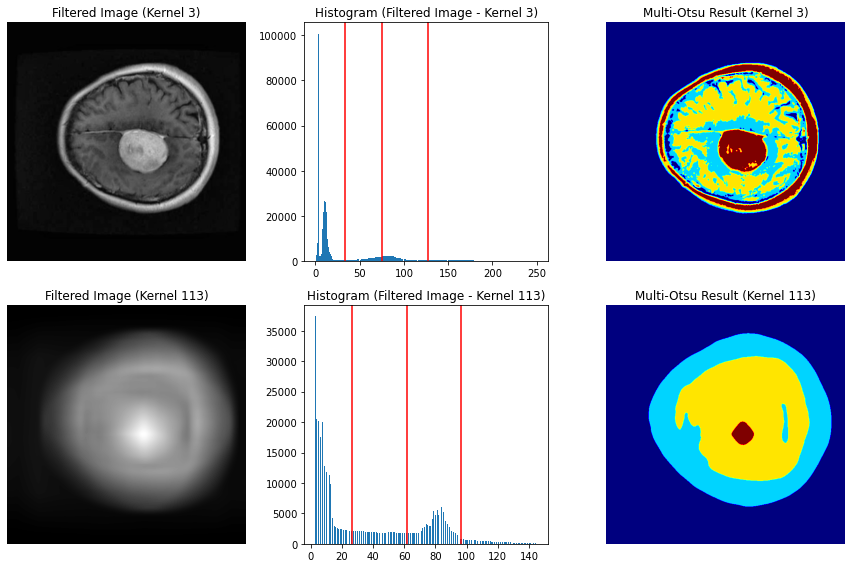

In [8]:
#apply the filters
wiener_kernel_3 = np.ones((3, 3), np.float32) / 9
wiener_filtered_image_3 = cv2.filter2D(image, -1, wiener_kernel_3)

wiener_kernel_113 = np.ones((113, 113), np.float32) / (113 * 113)
wiener_filtered_image_113 = cv2.filter2D(image, -1, wiener_kernel_113)


# Calculate multi-Otsu thresholds
thresholds = threshold_multiotsu(wiener_filtered_image_3, classes=4)
thresholdss = threshold_multiotsu(wiener_filtered_image_113, classes=4)


# Segment the image into different regions
regions = np.digitize(wiener_filtered_image_3, bins=thresholds)
regionss = np.digitize(wiener_filtered_image_113, bins=thresholds)


# Display the filtered images, histograms, and multi-Otsu results
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Filtered images
axes[0, 0].imshow(wiener_filtered_image_3, cmap='gray')
axes[0, 0].set_title('Filtered Image (Kernel 3)')
axes[0, 0].axis('off')

axes[1, 0].imshow(wiener_filtered_image_113, cmap='gray')
axes[1, 0].set_title('Filtered Image (Kernel 113)')
axes[1, 0].axis('off')

# Histograms with threshold lines
axes[0, 1].hist(wiener_filtered_image_3.ravel(), bins=255)
for thresh in thresholds:
    axes[0, 1].axvline(thresh, color='r')
axes[0, 1].set_title('Histogram (Filtered Image - Kernel 3)')

axes[1, 1].hist(wiener_filtered_image_113.ravel(), bins=255)
for thresh in thresholdss:
    axes[1, 1].axvline(thresh, color='r')
axes[1, 1].set_title('Histogram (Filtered Image - Kernel 113)')

# Multi-Otsu results
axes[0, 2].imshow(regions, cmap='jet')
axes[0, 2].set_title('Multi-Otsu Result (Kernel 3)')
axes[0, 2].axis('off')

axes[1, 2].imshow(regionss, cmap='jet')
axes[1, 2].set_title('Multi-Otsu Result (Kernel 113)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


# Calculate the measures


In [9]:
# Calculate PSNR, SSIM, Dice Coefficient, Jaccard Index, and Sørensen-Dice Coefficient for filtered image with kernel 3*3
psnr_value = psnr(image, regions)
ssim_value = ssim(image, regions)
dsc_value = dice_coefficient(image, regions)
ji_value = jaccard_index(image, regions)

print(" ********* for kernel 3*3 *********")
print()

#print the values
print("the psnr : ",psnr_value)
print()
print("the ssim : ",ssim_value)
print()
print("Dice Similarity Coefficient : ", dsc_value)
print()
print("Jaccard Index : ", ji_value)
print()
print()

# Calculate PSNR, SSIM, Dice Coefficient, Jaccard Index, and Sørensen-Dice Coefficient for filtered image with kernel 53*53
psnr_valuee = psnr(image, regionss)
ssim_valuee = ssim(image, regionss)
dsc_valuee = dice_coefficient(image, regionss)
ji_valuee = jaccard_index(image, regionss)

print(" ********* for kernel 53*53 ********* ")
print()

#print the values
print("the psnr : ",psnr_valuee)
print()
print("the ssim : ",ssim_valuee)
print()
print("Dice Similarity Coefficient : ", dsc_valuee)
print()
print("Jaccard Index : ", ji_valuee)


C:\Users\Y\AppData\Local\Temp/ipykernel_8520/3990639993.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_value = psnr(image, regions)
C:\Users\Y\AppData\Local\Temp/ipykernel_8520/3990639993.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_value = ssim(image, regions)
C:\Users\Y\AppData\Local\Temp/ipykernel_8520/3990639993.py:22: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_valuee = psnr(image, regionss)
C:\Users\Y\AppData\Local\Temp/ipykernel_8520/3990639993.py:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_valuee = ssim(image, regionss)


 ********* for kernel 3*3 *********

the psnr :  12.770432584638876

the ssim :  0.14249494966138312

Dice Similarity Coefficient :  0.017482172640580763

Jaccard Index :  0.32205372405372407


 ********* for kernel 53*53 ********* 

the psnr :  12.734104370886989

the ssim :  0.15679175875794607

Dice Similarity Coefficient :  0.022553879303923153

Jaccard Index :  0.4158706205252928


# multi-otsu thresholding with mean filter

Time taken for multi otsu function: 0.5913972854614258 seconds
Time taken for multi otsu function: 0.1122899055480957 seconds


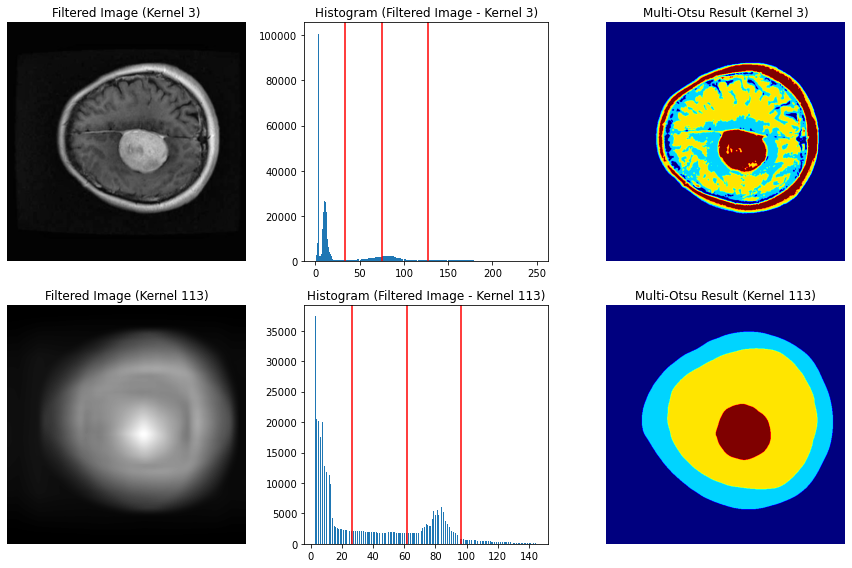

In [10]:
# Define mean filter kernels
mean_kernel_3 = np.ones((3, 3), np.float32) / 9
mean_kernel_113 = np.ones((113, 113), np.float32) / (113 * 113)

# Apply mean filtering
mean_filtered_image_3 = cv2.filter2D(image, -1, mean_kernel_3)
mean_filtered_image_113 = cv2.filter2D(image, -1, mean_kernel_113)

# Calculate multi-Otsu thresholds
thresholds = threshold_multiotsu(mean_filtered_image_3, classes=4)
thresholdss = threshold_multiotsu(mean_filtered_image_113, classes=4)

# Segment the image into different regions
regions = np.digitize(mean_filtered_image_3, bins=thresholds)
regionss = np.digitize(mean_filtered_image_113, bins=thresholdss)

# Display the filtered images, histograms, and multi-Otsu results
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Filtered images
axes[0, 0].imshow(mean_filtered_image_3, cmap='gray')
axes[0, 0].set_title('Filtered Image (Kernel 3)')
axes[0, 0].axis('off')

axes[1, 0].imshow(mean_filtered_image_113, cmap='gray')
axes[1, 0].set_title('Filtered Image (Kernel 113)')
axes[1, 0].axis('off')

# Histograms with threshold lines
axes[0, 1].hist(mean_filtered_image_3.ravel(), bins=255)
for thresh in thresholds:
    axes[0, 1].axvline(thresh, color='r')
axes[0, 1].set_title('Histogram (Filtered Image - Kernel 3)')

axes[1, 1].hist(mean_filtered_image_113.ravel(), bins=255)
for thresh in thresholdss:
    axes[1, 1].axvline(thresh, color='r')
axes[1, 1].set_title('Histogram (Filtered Image - Kernel 113)')

# Multi-Otsu results
axes[0, 2].imshow(regions, cmap='jet')
axes[0, 2].set_title('Multi-Otsu Result (Kernel 3)')
axes[0, 2].axis('off')

axes[1, 2].imshow(regionss, cmap='jet')
axes[1, 2].set_title('Multi-Otsu Result (Kernel 113)')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()



# Calculate the measures


In [11]:
# Calculate PSNR, SSIM, Dice Coefficient, Jaccard Index, and Sørensen-Dice Coefficient for filtered image with kernel 3*3
psnr_value = psnr(image, regions)
ssim_value = ssim(image, regions)
dsc_value = dice_coefficient(image, regions)
ji_value = jaccard_index(image, regions)

print(" ********* for kernel 3*3 ********* ")
print()

#print the values
print("the psnr : ",psnr_value)
print()
print("the ssim : ",ssim_value)
print()
print("Dice Similarity Coefficient : ", dsc_value)
print()
print("Jaccard Index : ", ji_value)
print()
print()

# Calculate PSNR, SSIM, Dice Coefficient, Jaccard Index, and Sørensen-Dice Coefficient for filtered image with kernel 113*113
psnr_valuee = psnr(image, regionss)
ssim_valuee = ssim(image, regionss )
dsc_valuee = dice_coefficient(image, regionss)
ji_valuee = jaccard_index(image, regionss)

print(" ********* for kernel 113*113 ********* ")
print() 

#print the values
print("the psnr : ",psnr_valuee)
print()
print("the ssim : ",ssim_valuee)
print()
print("Dice Similarity Coefficient : ", dsc_valuee)
print()
print("Jaccard Index : ", ji_valuee)



C:\Users\Y\AppData\Local\Temp/ipykernel_8520/2155897497.py:2: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_value = psnr(image, regions)
C:\Users\Y\AppData\Local\Temp/ipykernel_8520/2155897497.py:3: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_value = ssim(image, regions)
C:\Users\Y\AppData\Local\Temp/ipykernel_8520/2155897497.py:22: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr_valuee = psnr(image, regionss)
C:\Users\Y\AppData\Local\Temp/ipykernel_8520/2155897497.py:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  ssim_valuee = ssim(image, regionss )


 ********* for kernel 3*3 ********* 

the psnr :  12.770432584638876

the ssim :  0.14249494966138312

Dice Similarity Coefficient :  0.017482172640580763

Jaccard Index :  0.32205372405372407


 ********* for kernel 113*113 ********* 

the psnr :  12.763796480090125

the ssim :  0.1647846931864641

Dice Similarity Coefficient :  0.02440470462404409

Jaccard Index :  0.4517537433703519


In [12]:
num_thresholds = 4


# genetic algorithm without filter

Time taken for multi otsu function: 0.7016847133636475 seconds
Time taken for genetic algorithm optimization: 0.17717957496643066 seconds


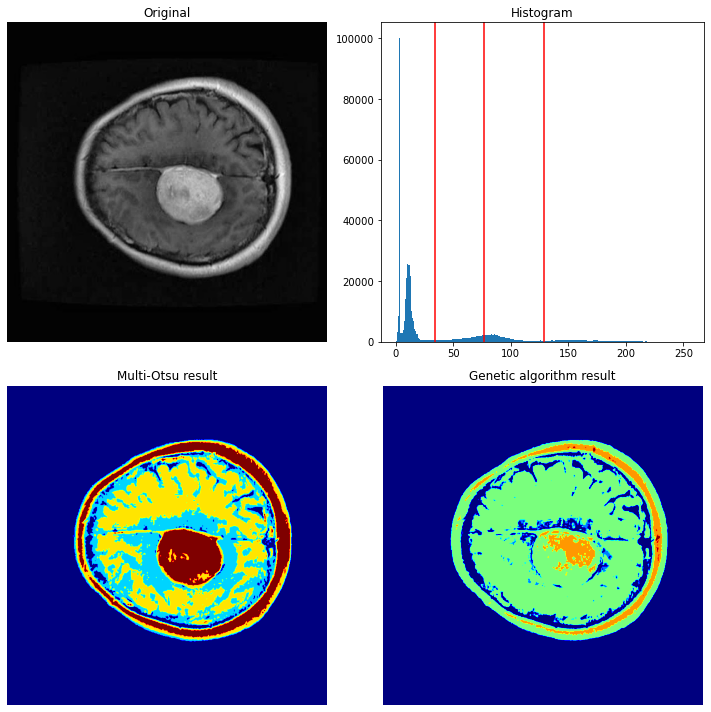

In [13]:


# Calculate multi-Otsu thresholds
thresholds = threshold_multiotsu(image, classes=num_thresholds)

# Run genetic algorithm to refine thresholds
best_thresholds = genetic_algorithm(image, num_thresholds)

# Apply thresholds to the image
thresholded_image_multiotsu = apply_multiotsu_thresholds(image, thresholds)
thresholded_image_genetic = apply_multiotsu_thresholds(image, best_thresholds)

# Display the original image, histogram, multi-Otsu result, and genetic result
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Original image
ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original')
ax[0, 0].axis('off')

# Histogram with threshold lines
ax[0, 1].hist(image.ravel(), bins=255)
ax[0, 1].set_title('Histogram')
for thresh in thresholds:
    ax[0, 1].axvline(thresh, color='r')

# Multi-Otsu result
ax[1, 0].imshow(thresholded_image_multiotsu, cmap='jet')  
ax[1, 0].set_title('Multi-Otsu result')
ax[1, 0].axis('off')

# Genetic algorithm result
ax[1, 1].imshow(thresholded_image_genetic, cmap='jet')  
ax[1, 1].set_title('Genetic algorithm result')
ax[1, 1].axis('off')

plt.tight_layout()
plt.show()



## 

###### Calculate the measures


In [14]:
# Calculate PSNR, SSIM, Dice Coefficient, Jaccard Index, and Sørensen-Dice Coefficient for thresholded image genetic
psnr_value = psnr(image, thresholded_image_genetic)
ssim_value = ssim(image, thresholded_image_genetic)
dsc_value = dice_coefficient(image, thresholded_image_genetic)
ji_value = jaccard_index(image, thresholded_image_genetic)

print(" ********* for thresholded image genetic ********* ")
print()

#print the values
print("the psnr : ",psnr_value)
print()
print("the ssim : ",ssim_value)
print()
print("Dice Similarity Coefficient : ", dsc_value)
print()
print("Jaccard Index : ", ji_value)
print()
print()

# Calculate PSNR, SSIM, Dice Coefficient, Jaccard Index, and Sørensen-Dice Coefficient for thresholded image multiotsu
psnr_valuee = psnr(image, thresholded_image_multiotsu)
ssim_valuee = ssim(image, thresholded_image_multiotsu )
dsc_valuee = dice_coefficient(image, thresholded_image_multiotsu)
ji_valuee = jaccard_index(image, thresholded_image_multiotsu)

print(" ********* for thresholded image multiotsu ********* ")
print()

#print the values
print("the psnr : ",psnr_valuee)
print()
print("the ssim : ",ssim_valuee)
print()
print("Dice Similarity Coefficient : ", dsc_valuee)
print()
print("Jaccard Index : ", ji_valuee)



 ********* for thresholded image genetic ********* 

the psnr :  20.546222636006313

the ssim :  0.32603690342642216

Dice Similarity Coefficient :  0.007852251139869156

Jaccard Index :  0.29161660561660563


 ********* for thresholded image multiotsu ********* 

the psnr :  16.114569837515756

the ssim :  0.30762194196559933

Dice Similarity Coefficient :  0.007361072783356071

Jaccard Index :  0.3186275946275946


#  genetic algorithm with mean filter 

Time taken for multi otsu function: 0.10400700569152832 seconds
Time taken for genetic algorithm optimization: 0.17036724090576172 seconds


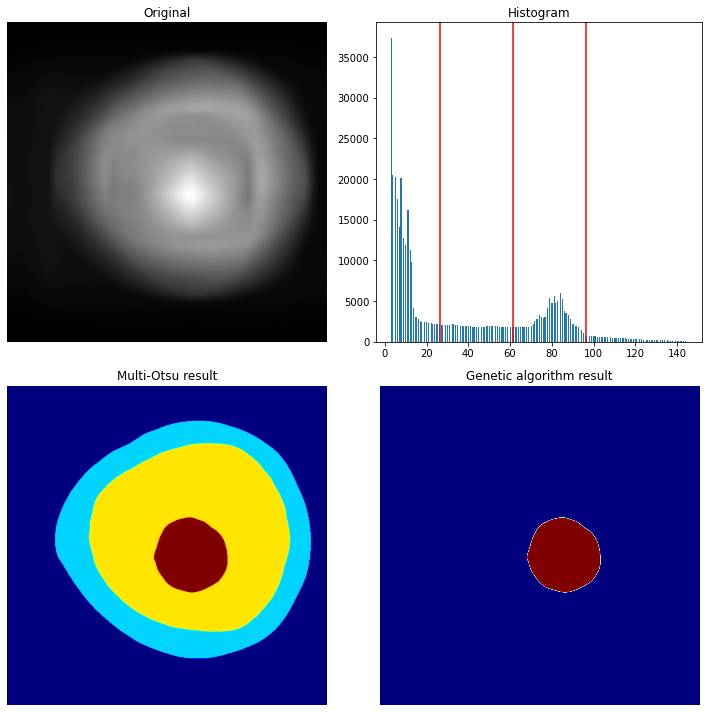

 ********* for thresholded image genetic ********* 

the psnr :  13.659215237065993

the ssim :  0.29230557107424104

Dice Similarity Coefficient :  0.0196292238542573

Jaccard Index :  0.999755859375


 ********* for thresholded image multiotsu ********* 

the psnr :  12.438335488035019

the ssim :  0.2641869205173281

Dice Similarity Coefficient :  0.008803109647902024

Jaccard Index :  0.4517537433703519




Time taken for genetic algorithm optimization: 0.21012306213378906 seconds


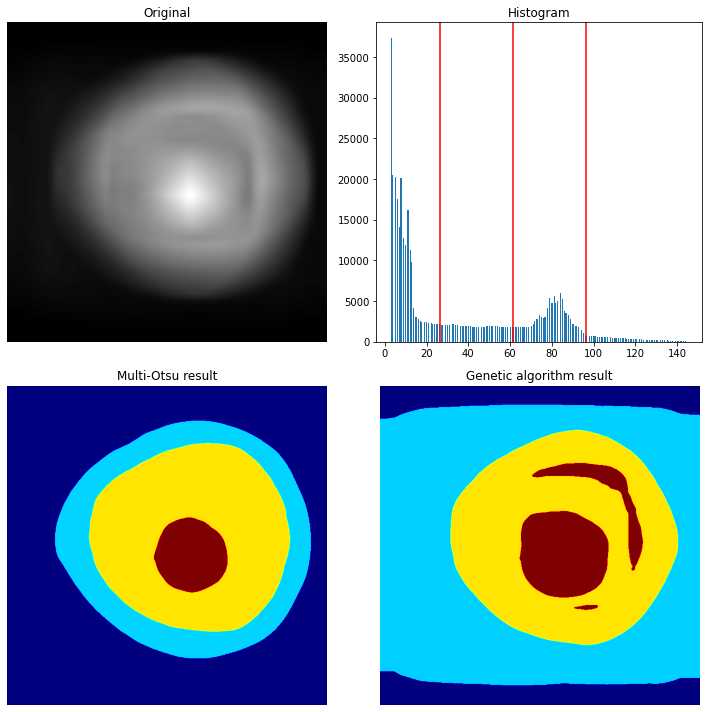

 ********* for thresholded image genetic ********* 

the psnr :  12.698774761170377

the ssim :  0.3074393113818169

Dice Similarity Coefficient :  0.01446895996643777

Jaccard Index :  0.85859619140625


 ********* for thresholded image multiotsu ********* 

the psnr :  12.438335488035019

the ssim :  0.2641869205173281

Dice Similarity Coefficient :  0.008803109647902024

Jaccard Index :  0.4517537433703519




Time taken for genetic algorithm optimization: 0.20323514938354492 seconds


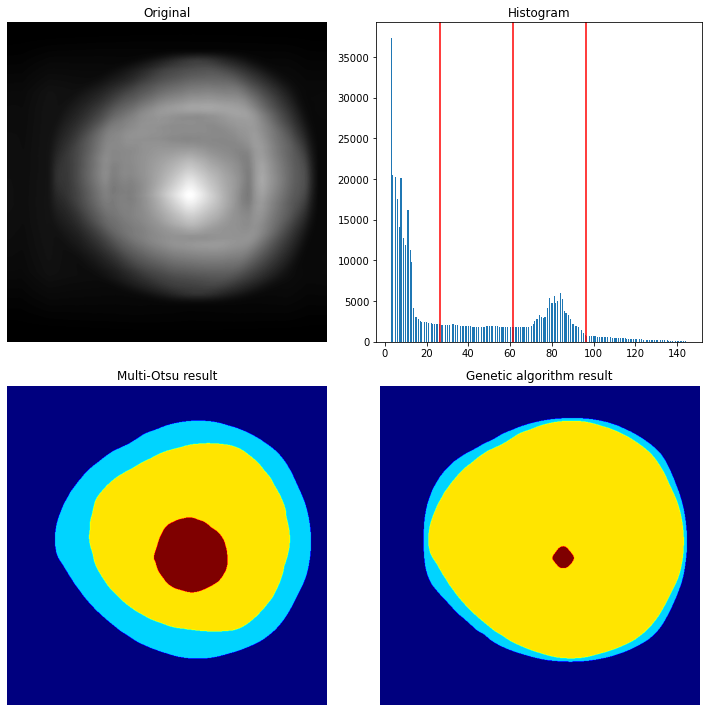

 ********* for thresholded image genetic ********* 

the psnr :  8.195638425706884

the ssim :  0.22522942038799226

Dice Similarity Coefficient :  0.012487756204844335

Jaccard Index :  0.999755859375


 ********* for thresholded image multiotsu ********* 

the psnr :  12.438335488035019

the ssim :  0.2641869205173281

Dice Similarity Coefficient :  0.008803109647902024

Jaccard Index :  0.4517537433703519




Time taken for genetic algorithm optimization: 0.22618556022644043 seconds


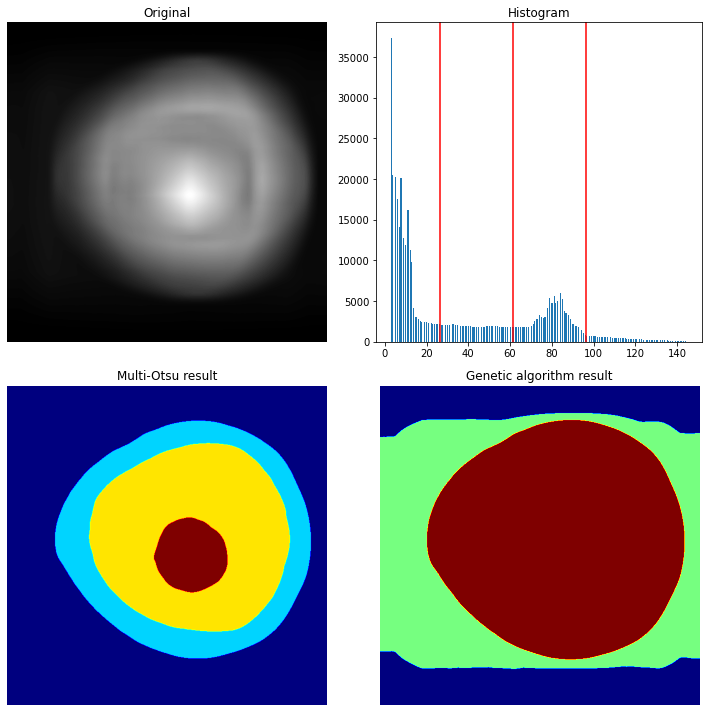

 ********* for thresholded image genetic ********* 

the psnr :  12.561736185864131

the ssim :  0.33426609196004464

Dice Similarity Coefficient :  0.013434823066008341

Jaccard Index :  0.7666533997817069


 ********* for thresholded image multiotsu ********* 

the psnr :  12.438335488035019

the ssim :  0.2641869205173281

Dice Similarity Coefficient :  0.008803109647902024

Jaccard Index :  0.4517537433703519




Time taken for genetic algorithm optimization: 0.1977214813232422 seconds


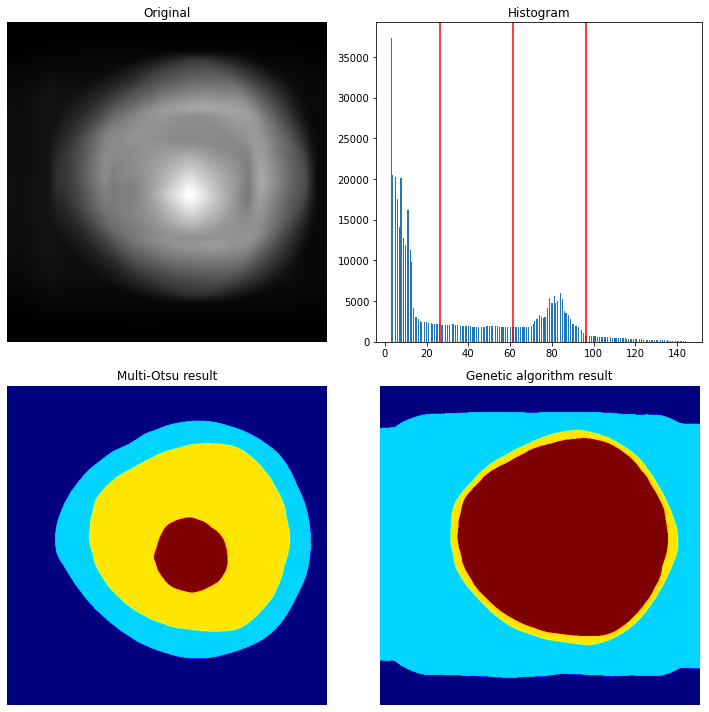

 ********* for thresholded image genetic ********* 

the psnr :  5.859281718767614

the ssim :  0.17876208185809048

Dice Similarity Coefficient :  0.010297772864576366

Jaccard Index :  0.999755859375


 ********* for thresholded image multiotsu ********* 

the psnr :  12.438335488035019

the ssim :  0.2641869205173281

Dice Similarity Coefficient :  0.008803109647902024

Jaccard Index :  0.4517537433703519




Time taken for genetic algorithm optimization: 0.21863913536071777 seconds


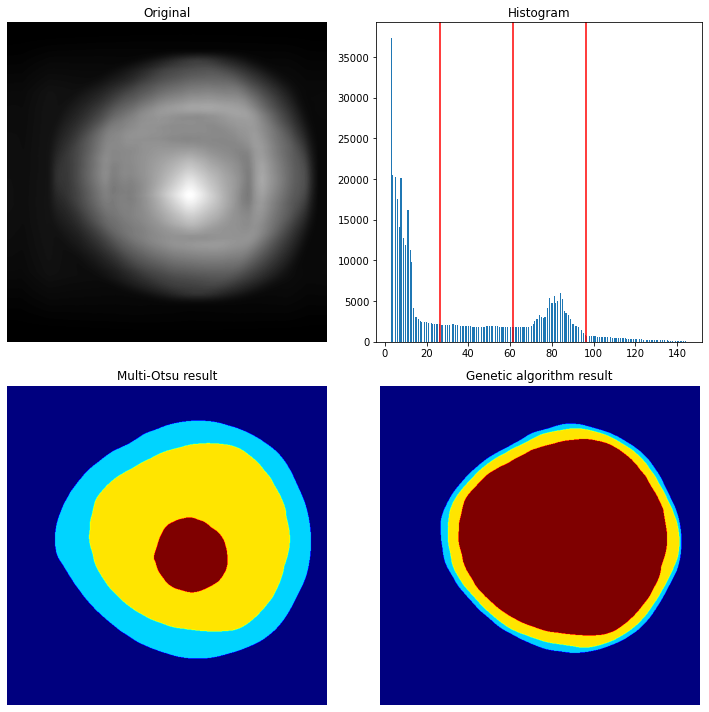

 ********* for thresholded image genetic ********* 

the psnr :  11.755857963166935

the ssim :  0.2556266043556989

Dice Similarity Coefficient :  0.007692790191610369

Jaccard Index :  0.4059420204920835


 ********* for thresholded image multiotsu ********* 

the psnr :  12.438335488035019

the ssim :  0.2641869205173281

Dice Similarity Coefficient :  0.008803109647902024

Jaccard Index :  0.4517537433703519




Time taken for genetic algorithm optimization: 0.20225214958190918 seconds


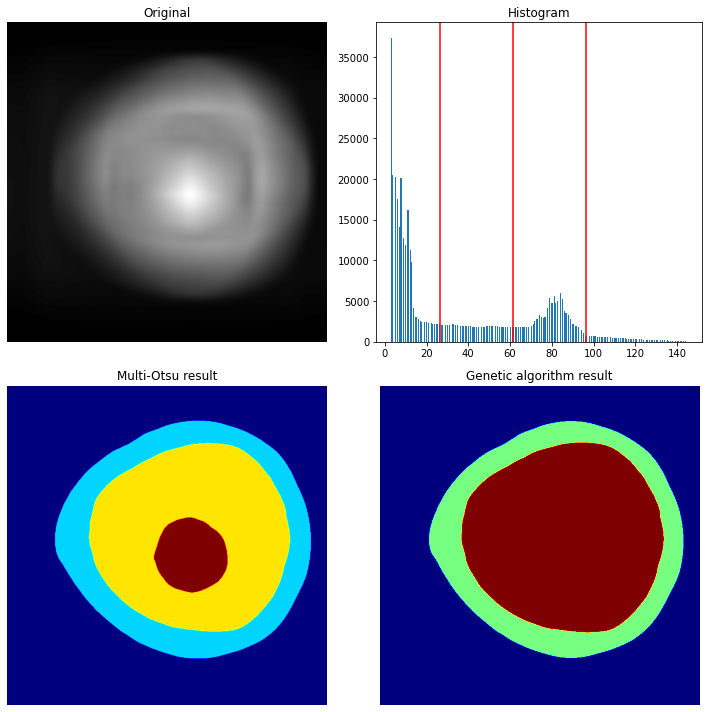

 ********* for thresholded image genetic ********* 

the psnr :  16.68436012617224

the ssim :  0.29156460817282054

Dice Similarity Coefficient :  0.010667996582475045

Jaccard Index :  0.44158095740420583


 ********* for thresholded image multiotsu ********* 

the psnr :  12.438335488035019

the ssim :  0.2641869205173281

Dice Similarity Coefficient :  0.008803109647902024

Jaccard Index :  0.4517537433703519




Time taken for genetic algorithm optimization: 0.1859593391418457 seconds


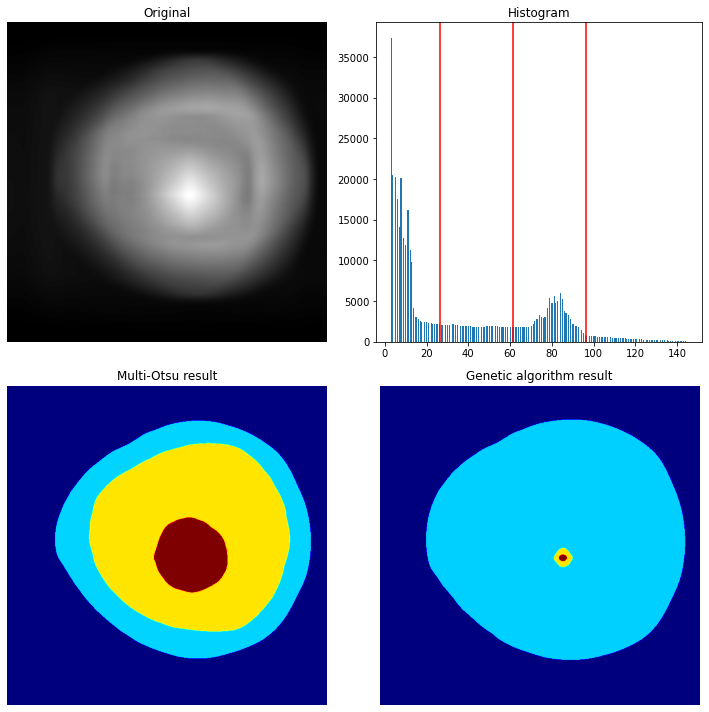

 ********* for thresholded image genetic ********* 

the psnr :  16.90638809255798

the ssim :  0.30374006597869313

Dice Similarity Coefficient :  0.014284693392088483

Jaccard Index :  0.4729735009425577


 ********* for thresholded image multiotsu ********* 

the psnr :  12.438335488035019

the ssim :  0.2641869205173281

Dice Similarity Coefficient :  0.008803109647902024

Jaccard Index :  0.4517537433703519




Time taken for genetic algorithm optimization: 0.19342255592346191 seconds


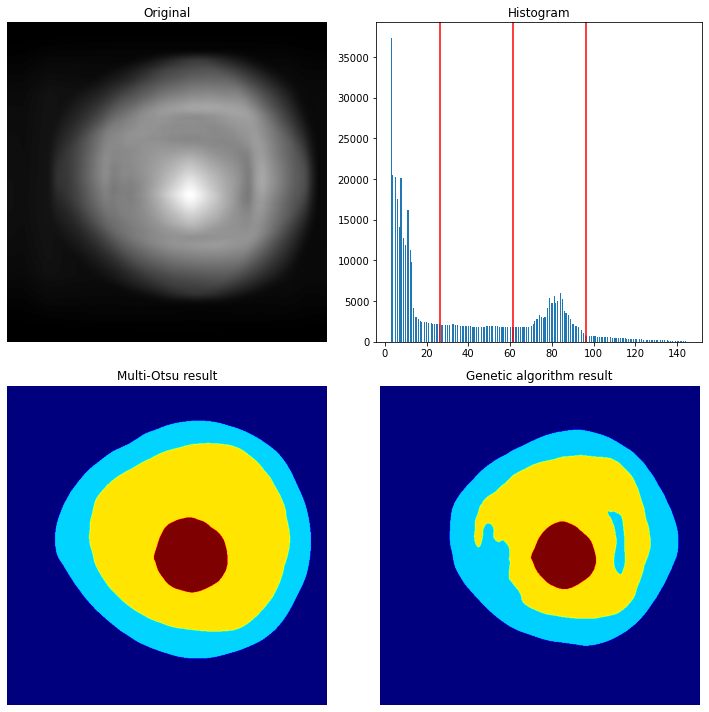

 ********* for thresholded image genetic ********* 

the psnr :  16.961315201108736

the ssim :  0.2736050810584677

Dice Similarity Coefficient :  0.00983949535941162

Jaccard Index :  0.3642206382578671


 ********* for thresholded image multiotsu ********* 

the psnr :  12.438335488035019

the ssim :  0.2641869205173281

Dice Similarity Coefficient :  0.008803109647902024

Jaccard Index :  0.4517537433703519




Time taken for genetic algorithm optimization: 0.16399240493774414 seconds


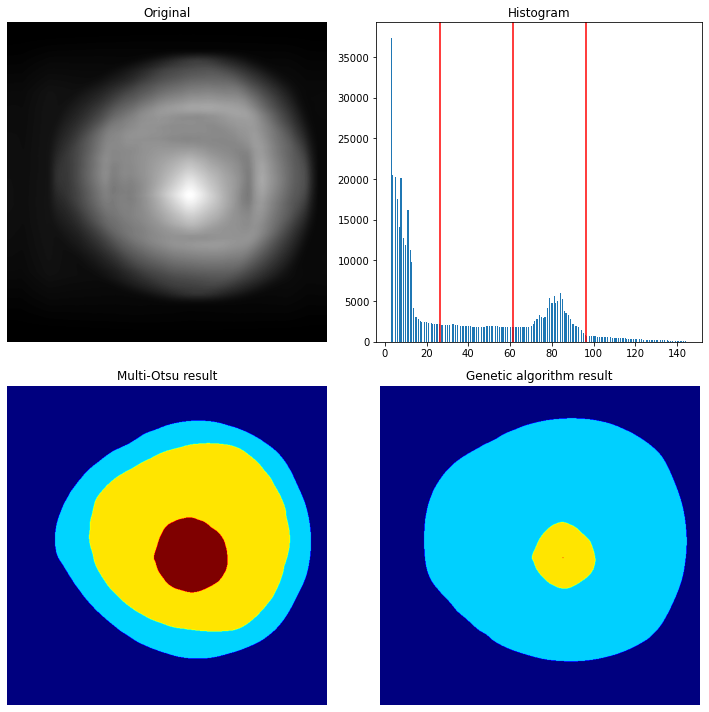

 ********* for thresholded image genetic ********* 

the psnr :  17.313274673476677

the ssim :  0.3144770551895413

Dice Similarity Coefficient :  0.014290879957291348

Jaccard Index :  0.4956070950664674


 ********* for thresholded image multiotsu ********* 

the psnr :  12.438335488035019

the ssim :  0.2641869205173281

Dice Similarity Coefficient :  0.008803109647902024

Jaccard Index :  0.4517537433703519






In [15]:
# Calculate multi-Otsu thresholds outside the loop since it doesn't change
thresholds = threshold_multiotsu(mean_filtered_image_113)
thresholded_image_multiotsuu = apply_multiotsu_thresholds(mean_filtered_image_113, thresholds)

for i in range(10):
   

    # Run genetic algorithm to refine thresholds
    best_thresholdss = genetic_algorithm(mean_filtered_image_113, num_thresholds)

    # Apply thresholds to the image
    thresholded_image_geneticc = apply_multiotsu_thresholds(mean_filtered_image_113, best_thresholdss)

    # Display the original image, histogram, multi-Otsu result, and genetic result
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

    # Original image
    ax[0, 0].imshow(mean_filtered_image_113, cmap='gray')
    ax[0, 0].set_title('Original')
    ax[0, 0].axis('off')

    # Histogram with threshold lines
    ax[0, 1].hist(mean_filtered_image_113.ravel(), bins=255)
    ax[0, 1].set_title('Histogram')
    for thresh in thresholdss:
        ax[0, 1].axvline(thresh, color='r')

    # Multi-Otsu result
    ax[1, 0].imshow(thresholded_image_multiotsuu, cmap='jet')  
    ax[1, 0].set_title('Multi-Otsu result')
    ax[1, 0].axis('off')

    # Genetic algorithm result
    ax[1, 1].imshow(thresholded_image_geneticc, cmap='jet')  
    ax[1, 1].set_title('Genetic algorithm result')
    ax[1, 1].axis('off')

    plt.tight_layout()
    plt.show()
    
        # Calculate PSNR, SSIM, Dice Coefficient, Jaccard Index, and Sørensen-Dice Coefficient
    psnr_value_gf = psnr(image, thresholded_image_geneticc)
    ssim_value_gf = ssim(image, thresholded_image_geneticc)
    dsc_value_gf = dice_coefficient(image, thresholded_image_geneticc)
    ji_value_gf = jaccard_index(image, thresholded_image_geneticc)

    print(" ********* for thresholded image genetic ********* ")
    print()
    print("the psnr : ",psnr_value_gf)
    print()
    print("the ssim : ",ssim_value_gf)
    print()
    print("Dice Similarity Coefficient : ", dsc_value_gf)
    print()
    print("Jaccard Index : ", ji_value_gf)
    print()
    print()

    # Calculate PSNR, SSIM, Dice Coefficient, Jaccard Index, and Sørensen-Dice Coefficient
    psnr_valuee_of = psnr(image, thresholded_image_multiotsuu)
    ssim_valuee_of = ssim(image, thresholded_image_multiotsuu )
    dsc_valuee_of = dice_coefficient(image, thresholded_image_multiotsuu)
    ji_valuee_of = jaccard_index(image, thresholded_image_multiotsuu)

    print(" ********* for thresholded image multiotsu ********* ")
    print()
    print("the psnr : ",psnr_valuee_of)
    print()
    print("the ssim : ",ssim_valuee_of)
    print()
    print("Dice Similarity Coefficient : ", dsc_valuee_of)
    print()
    print("Jaccard Index : ", ji_valuee_of)
    print()
    print()
    print()
    print()


